<a href="https://colab.research.google.com/github/ChelsaMJ/Vision-Based-Detection-of-Emotion-Suppression-Using-Facial-Motor-Dynamics/blob/main/03_audio_visual_latency_voxceleb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In unconstrained, real-world videos, does facial activation precede speech, and can we observe variable delays that are consistent with inhibition / regulation?

### Understanding dataset

VoxCeleb provides:
- real faces
- real speech
- no acting
- no scripted silence
- no emotion labels

Which is PERFECT for:

- latency
- inhibition
- temporal analysis

### What signals we extract?

From vox2_test_mp4

We extract:
- frames (OpenCV)
- facial landmarks (MediaPipe)
- facial motion over time
- face activation onset

From vox2_test_aac

We extract:
- waveform (librosa)
- silence → speech transition
- speech onset time

# Setup & imports

In [2]:
!pip install librosa opencv-python

In [3]:
!pip install mediapipe==0.10.21


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protob

## Mount Drive and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import cv2
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

import mediapipe as mp


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paths & sample selection

In [2]:
BASE = "/content/drive/MyDrive/Research Dataset/datasets/voxCeleb_test"

VIDEO_BASE = os.path.join(BASE, "vox2_test_mp4", "mp4")
AUDIO_BASE = os.path.join(BASE, "vox2_test_aac", "aac")

### We WILL:

- Use MediaPipe Face Mesh as a feature extractor

- Track specific muscle-related regions:
  - Eyebrows (AU1, AU2 proxy)
  - Eyes (blink / tension proxy)
  - Mouth corners & lips (AU12, AU25 proxy)
- Measure temporal dynamics, not static emotion

This aligns perfectly with:
> Emotion suppression + thought-to-speech latency

## Face Mesh sanity test

In [4]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

test_video = glob.glob(VIDEO_BASE + "/**/*.mp4", recursive=True)[0]

cap = cv2.VideoCapture(test_video)
ret, frame = cap.read()
cap.release()

rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)

print("Face detected:", results.multi_face_landmarks is not None)


Face detected: True


## Facial activation detection

This function detects the first sustained facial motion, not noise.

In [5]:
import numpy as np

KEY_LANDMARKS = [
    33, 133, 159, 145,      # left eye
    362, 263, 386, 374,    # right eye
    70, 105, 336, 300,     # eyebrows
    61, 291, 13, 14        # mouth
]

def detect_facial_onset(
    video_path,
    fps_target=5,
    motion_thresh=0.002,
    min_consecutive=2
):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    step = max(1, int(fps // fps_target))

    prev_pts = None
    motion_hits = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_idx % step != 0:
            continue

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)

        if results.multi_face_landmarks:
            lm = results.multi_face_landmarks[0].landmark
            pts = np.array([[lm[i].x, lm[i].y] for i in KEY_LANDMARKS])

            if prev_pts is not None:
                motion = np.linalg.norm(pts - prev_pts)

                if motion > motion_thresh:
                    motion_hits += 1
                    if motion_hits >= min_consecutive:
                        time_sec = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
                        cap.release()
                        return time_sec
                else:
                    motion_hits = 0

            prev_pts = pts

    cap.release()
    return None


## Audio–video path matcher

In [10]:
def match_audio(video_path):
    return video_path \
        .replace("vox2_test_mp4/mp4", "vox2_test_aac/aac") \
        .replace(".mp4", ".m4a")


## Speech onset detection

In [15]:
import subprocess
import tempfile
import os
import librosa
import numpy as np

def detect_speech_onset(audio_path, sr=16000, rms_thresh=0.02, min_silence=0.2):
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        tmp_wav = tmp.name

    subprocess.run(
        ["ffmpeg", "-y", "-i", audio_path, "-ac", "1", "-ar", str(sr), tmp_wav],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

    y, sr = librosa.load(tmp_wav, sr=sr)
    os.remove(tmp_wav)

    rms = librosa.feature.rms(y=y)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr)

    rms = rms / rms.max()

    silence_frames = int(min_silence * sr / 512)
    silent_count = 0

    for i, v in enumerate(rms):
        if v < rms_thresh:
            silent_count += 1
        else:
            if silent_count >= silence_frames:
                return times[i]
            silent_count = 0

    return times[0]

## SMALL SAMPLE TEST

In [16]:
test_video = glob.glob(VIDEO_BASE + "/**/*.mp4", recursive=True)[0]
test_audio = match_audio(test_video)

print("Video:", test_video)
print("Audio:", test_audio)

face_t = detect_facial_onset(test_video)
speech_t = detect_speech_onset(test_audio)

print("Facial onset:", face_t)
print("Speech onset:", speech_t)
print("Latency:", None if face_t is None or speech_t is None else speech_t - face_t)


Video: /content/drive/MyDrive/Research Dataset/datasets/voxCeleb_test/vox2_test_mp4/mp4/id09017/_GiXdhxaZRk/00178.mp4
Audio: /content/drive/MyDrive/Research Dataset/datasets/voxCeleb_test/vox2_test_aac/aac/id09017/_GiXdhxaZRk/00178.m4a
Facial onset: 0.56
Speech onset: 0.0
Latency: -0.56


#### Negative latency = speech already active before new facial activation

Expected:
  - Both onsets are non-null
  - Latency is reasonable (≈ -0.5 to +1.5 sec)

## Full VoxCeleb loop

In [17]:
video_files = glob.glob(VIDEO_BASE + "/**/*.mp4", recursive=True)
video_files = video_files[:30]

records = []

for vpath in video_files:
    apath = match_audio(vpath)
    if not os.path.exists(apath):
        continue

    face_onset = detect_facial_onset(vpath)
    speech_onset = detect_speech_onset(apath)

    speech_started_before = (speech_onset == 0.0)

    if face_onset is None or speech_onset is None:
        continue

    records.append({
        "video": os.path.basename(vpath),
        "facial_onset_sec": face_onset,
        "speech_onset_sec": speech_onset,
        "latency_sec": speech_onset - face_onset,
        "speech_preexisting": speech_started_before
        })


df = pd.DataFrame(records)
df

,video,facial_onset_sec,speech_onset_sec,latency_sec,speech_preexisting
0,00178.mp4,0.56,0.000,-0.560,True
1,00175.mp4,0.56,0.000,-0.560,True
2,00172.mp4,0.56,0.000,-0.560,True
3,00171.mp4,0.56,0.000,-0.560,True
4,00170.mp4,0.56,6.784,6.224,False
5,00177.mp4,0.56,0.000,-0.560,True
6,00176.mp4,0.56,0.000,-0.560,True
7,00169.mp4,0.56,0.000,-0.560,True
8,00174.mp4,0.56,0.000,-0.560,True
9,00173.mp4,0.56,0.000,-0.560,True


## Visualize latency distribution

<Axes: >

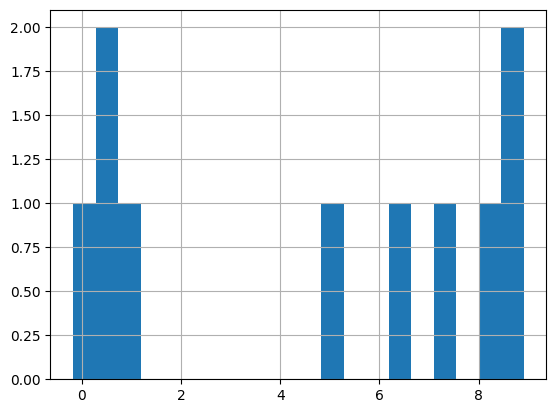

In [21]:
df_clean = df[df["speech_preexisting"] == False] #Only these are valid for latency analysis.
df_clean["latency_sec"].hist(bins=20)

# plt.figure(figsize=(8,5))
# plt.hist(df["latency_sec"], bins=15)
# plt.xlabel("Audio–Visual Latency (sec)")
# plt.ylabel("Count")
# plt.title("Audio–Visual Latency in VoxCeleb (Real-world)")
# plt.show()

## Save results